In [1]:
#The only difference in the V2/V3 code should be due to the stimulus start information
#use difference in length of video timestamps and audio files to determine time of stimulus

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Ellipse
import matplotlib.patches as patches
import librosa
import math

%run V2_graphing_functions.ipynb

In [3]:
#Use this for all adjustable values 
#input file paths here (include .csv):

video_path = r'\\10.25.16.5\yaochen\Active\DLC\Final_Models\Hanna\escape_behavior_HannaJachna_2024-07-8\increaseNV3\coords_csv\CoordM3variation3IncreaseN_videoP2DLC_resnet50_escape_behavior_2Jun13shuffle1_1030000_filtered_day.csv'
time_path = r'\\10.25.16.5\yaochen\Active\Hanna\Escape_behavior\variation3IncreasingN\videoTime\M3variation3IncreaseN_videoTimeP20.csv'
audio_path = r'\\10.25.16.5\yaochen\Active\Hanna\Escape_behavior\variation3IncreasingN\audioWAV\M3variation3IncreaseN_audioP2.wav'

north_pixel = 26
south_pixel = 462
east_pixel = 570
west_pixel = 101
shelter_x_pixel = 526
shelter_y_pixel = 263

platform_center_x = west_pixel + ((east_pixel-west_pixel)/2)
platform_center_y = north_pixel + ((south_pixel-north_pixel)/2)

#input info from time_and_audio info notebook (either from audacity or bonsai)
stimulus_start = 78.143 #stimulus start time
escape_time = 78.5 #time mouse reaches shelter location

#set sigma for gaussian filter - look into how to decide 
sigma = 2

In [4]:
#manually decide?
freezing_response = False

#does the mouse turn its head in the shortest angle to shelter
small_angle = True

In [5]:
#read in DLC data (video_path), convert all points to cm, and center platform at 0,0
#return converted coordinates for all in dataframe called coords, return new coordinates for the shelter and the x and y diam
#parameters: N, S, E, W, shelter_x, shelter_y, video path (pixel information and DLC data defined in cell 2)

#input cooridnates in pixels and output coordinates in cm with 0,0 set as the center of platform. 
shelter_x, shelter_y, x_diam, y_diam, coords = convert_data(north_pixel, south_pixel, east_pixel, west_pixel, shelter_x_pixel, shelter_y_pixel, video_path)

In [6]:
#replace any mouse skeleton points with likelihood < .9 with NA (stored in coords)
#coords dataframe is filled with NA when LT<.9, coords_scaled has interpolated data for NA values
#returns new df (coord_scaled) with low threshold values interpolated

#parameters: likelihood threshold and dataframe with DLC data
#at this point in the code, coords is a dataframe that stores all of the values from DLC (but stored as cm rather than as pixels)

coord_scaled = filter_data(.9, coords) 
#for some reason, the coord_scaled values still have NaN
print(coord_scaled['nose_x'])

#The code below is included as a test to make sure that the interpolation is occuring. Note that there are still some NaN vlaues included in the interpolated column. This is because the first values in the column were NaN. 
# Count NaN values
nan_count = coord_scaled['nose_x'].isna().sum()
# Print the count of NaN values
print(f"Number of NaN values: {nan_count}")
# Count NaN values
nan_count = coords['nose_x'].isna().sum()
# Print the count of NaN values
print(f"Number of NaN values: {nan_count}")

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
4448   -5.590603
4449   -5.590603
4450   -5.590603
4451   -5.590603
4452   -5.590603
Name: nose_x, Length: 4453, dtype: float64
Number of NaN values: 33
Number of NaN values: 2104


In [7]:
#add column for time in seconds for both coords (na values) and coord_scaled (interpolated). stimulus at 0s.
#choose which stimulus to look at - 1 or 2 

#parameters: path to bonsai video timestamps, dataframe, audio path (stimulus timestamps from bonsai), which stimulus you want to look at
escape_estimate = audio_timing(stimulus_start, audio_path, time_path, escape_time, coord_scaled)
escape_estimate = audio_timing(stimulus_start, audio_path, time_path, escape_time, coords) 

#compare audio_path (which = \\10.25.16.5\yaochen\Active\Lindsey\set_up_testing\V2\Audio\M1_P2_6_17_24_audio.wav) and video_path (which = \\10.25.16.5\yaochen\Active\DLC\Final_Models\Hanna\escape_behavior_HannaJachna_2024-07-8\Tested_V2\coords_csv\CoordM1_P2_6_17_24_videoDLC_resnet50_escape_behavior_2Jun13shuffle1_1030000_filtered_day.csv)

In [8]:
#adds 3 new columns: 1 is an average of all points to use instead of the center of the mouse, another is averaged upper body (spine1, center) and the last is averaged head (nose, head, ears)
#more robust to use average of multiple points vs a single variable point (esp when looking at head angle bc of nose)

#parameters: dataframe
average_points(coords)
average_points(coord_scaled)

In [9]:
#calculate displacement as 'displacement'

#parameters: converted shelter_x, converted shelter_y, dataframe
displacement(shelter_x, shelter_y, coord_scaled) 
displacement(shelter_x, shelter_y, coords) 

In [10]:
#calculate speed as 'speed' and change in displacement as 'delta_vector' (use delta vector for linearity calculations)

#parameters: dataframe
total_distance = speed(coord_scaled) 
total_distance_coords = speed(coords) 

In [11]:
#calculate head angle as 'head_angle'

#parameters: converted shelter_x, converted shelter_y, dataframe
angle(shelter_x, shelter_y, coord_scaled) 
angle(shelter_x, shelter_y, coords) 

In [12]:
#calculate head angle speed as 'angle_speed'
#haven't assessed

#parameters: dataframe
angle_speed(coord_scaled) 
angle_speed(coords) 

In [13]:
#determines more precise time for escape - either when mouse reaches shelter border OR gets closest

#parameters: converted shelter x, converted shelter y, estimate for shelter reaching time, dataframe
escape_done = escape_timeframe(shelter_x, shelter_y, escape_estimate, coord_scaled)

In [14]:
#finds linearity ratio 

#parameters: shelter reaching time found in cell 12, dataframe
ratio, initial_displacement, total_distance = linearity_ratio(0,escape_done, coord_scaled)

In [15]:
#determine whether response is classified as an escape - look at time, linearity, and shelter reach

#parameters: shelter reaching time, converted shelter x, converted shelter y, dataframe, desired percent shelter expansion, time, linearity cutoffs
escape = escape_response(escape_done, shelter_x, shelter_y, coord_scaled, 30, 12, 1.1)
print(escape)

False


In [16]:
#can edit code to use this dataframe in above graphs, have this defined to pass into compiled mice. Apply filter to displacement, speed, angle, angle speed (angle speed not accurate)

#parameter: sigma, dataframe
coord_scaled_smooth = smooth_curve(sigma, coord_scaled)

0.47024800000292544


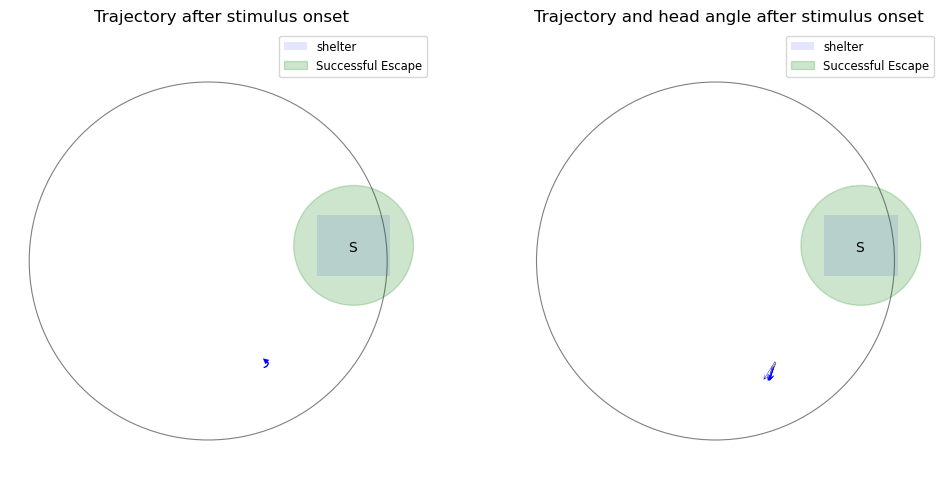

In [17]:
#parameters: converted shelter x, converted shelter y, converted x diameter, converted y diameter, start time, stop time, dataframe
#if moves away from shelter or freezes use escape estimate or you get an empty df 

trajectories(shelter_x, shelter_y, x_diam, y_diam,0, escape_done, coord_scaled)

print(escape_done)

<module 'matplotlib.pyplot' from 'C:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

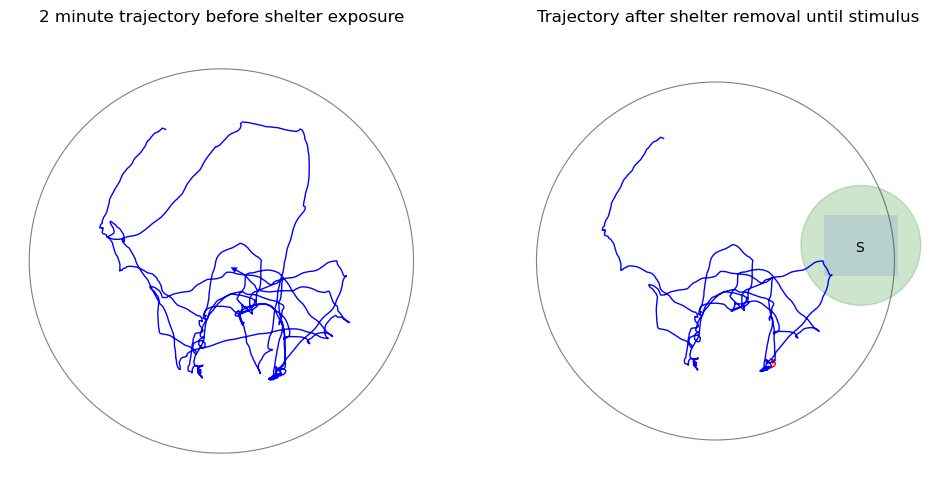

In [18]:
#trajectory for 2 minutes of start of P2 video, trajectory 1 minute before and through escape
#parameters: converted shelter x, converted shelter y, converted x diam, converted y diam, shelter reaching time, dataframe
#if moves away from shelter or freezes use escape estimate or you get an empty df 

before_shelter_trajectory(shelter_x, shelter_y, x_diam, y_diam, escape_done, coord_scaled)

<module 'matplotlib.pyplot' from 'C:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

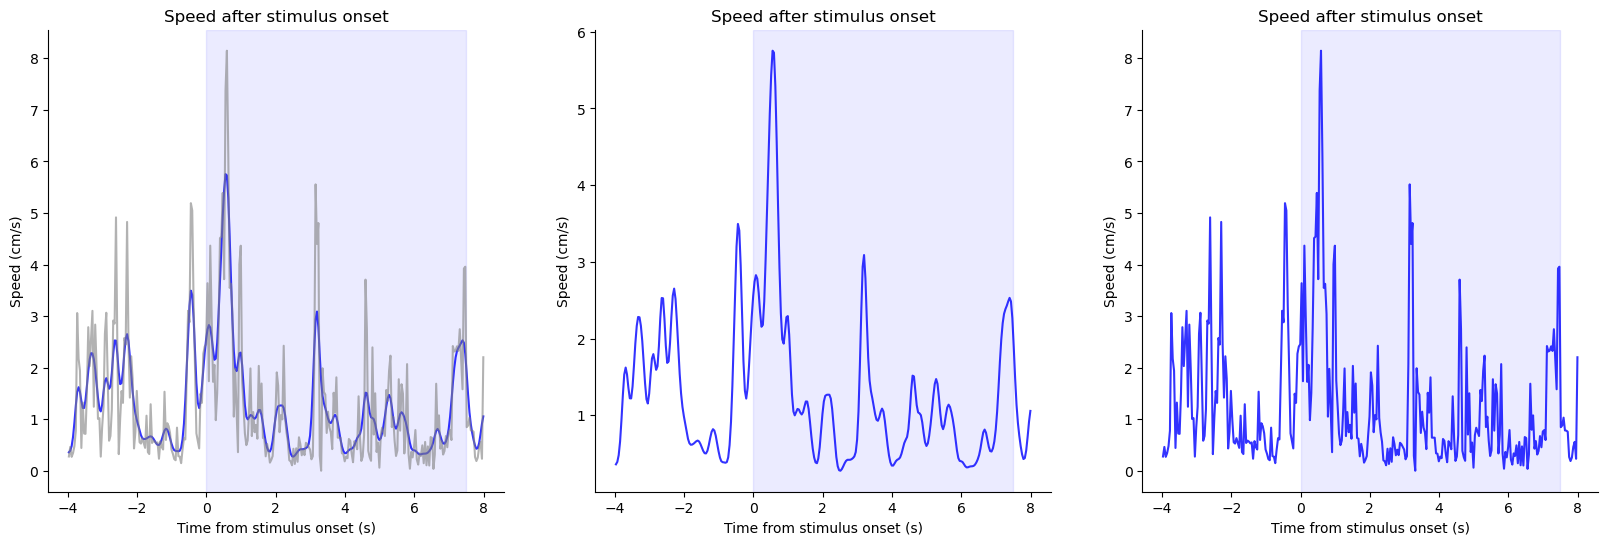

In [19]:
#plot intermediate steps - raw and with gaussian filter
#the below code specifies that there should be 3 figures, 3 columns, and 1 row. 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

#parameters: ax, start time, stop time, dataframe, apply filter?, overlay filter and raw?, for vertical alignment? (includ labels or not), sigma value
speed_figure(ax1, -4, 8, coord_scaled, False, True, False, sigma)
speed_figure(ax2, -4, 8, coord_scaled, True, False, False, sigma)
speed_figure(ax3, -4, 8, coord_scaled, False, False, False, sigma)

<module 'matplotlib.pyplot' from 'C:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

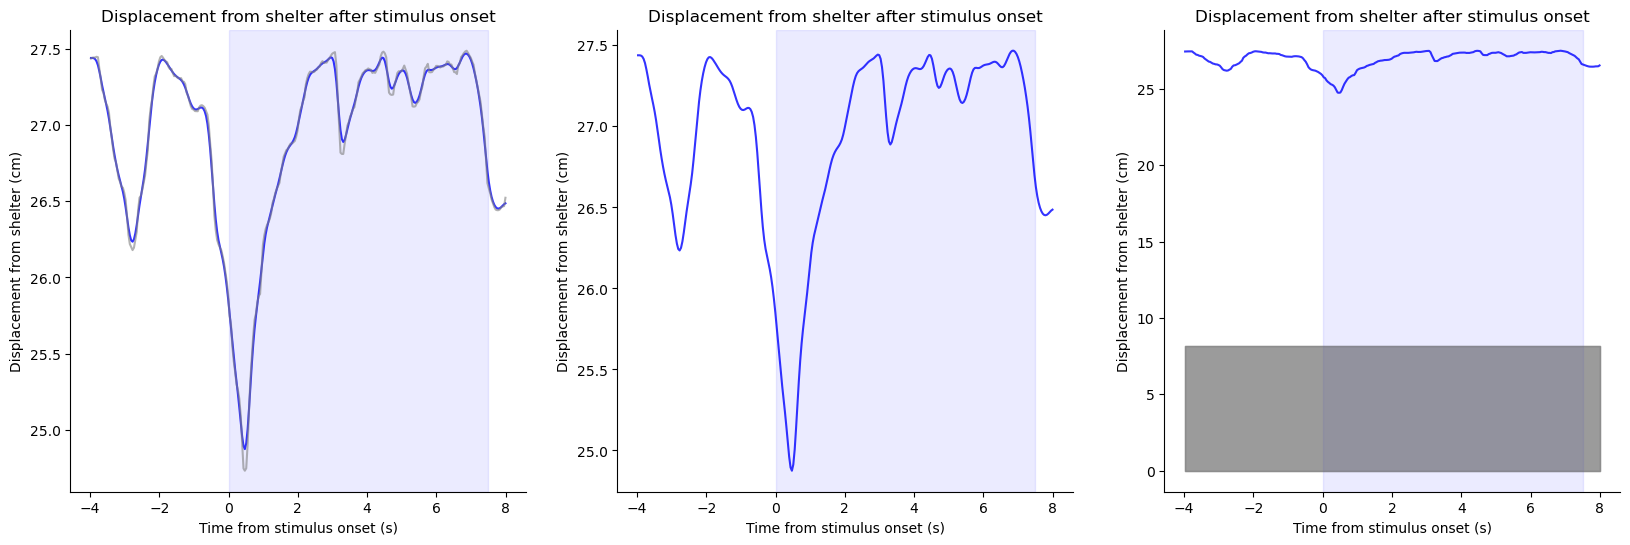

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

displacement_figure(ax1, -4, 8, coord_scaled, False, True, False,sigma)
displacement_figure(ax2, -4, 8, coord_scaled, True, False, False,sigma)
displacement_figure(ax3, -4, 8, coord_scaled, False, False, False,sigma)


<module 'matplotlib.pyplot' from 'C:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

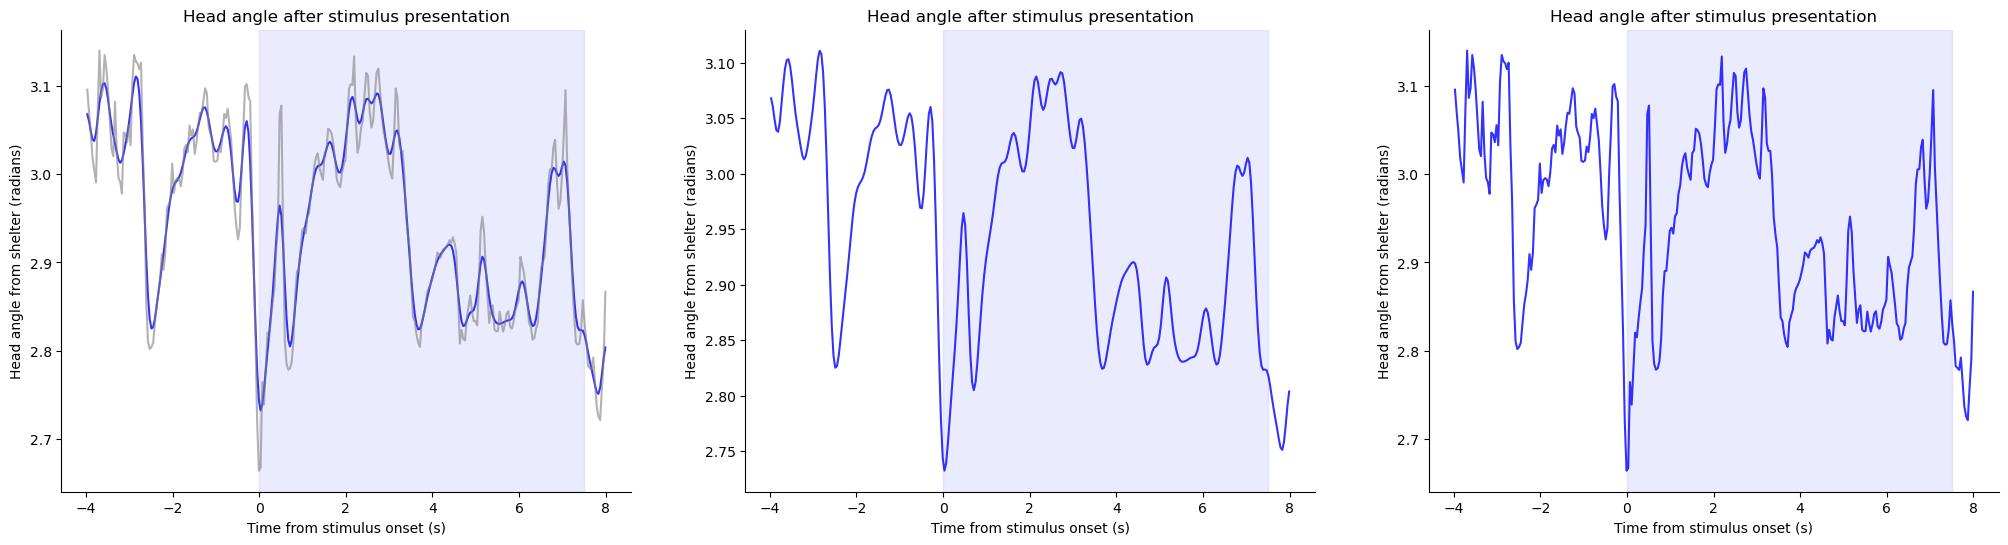

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 6))

head_angle_figure(ax1, -4, 8, coord_scaled, False, True, False,sigma)
head_angle_figure(ax2, -4, 8, coord_scaled, True, False, False,sigma)
head_angle_figure(ax3, -4, 8, coord_scaled, False, False,False, sigma)

<module 'matplotlib.pyplot' from 'C:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

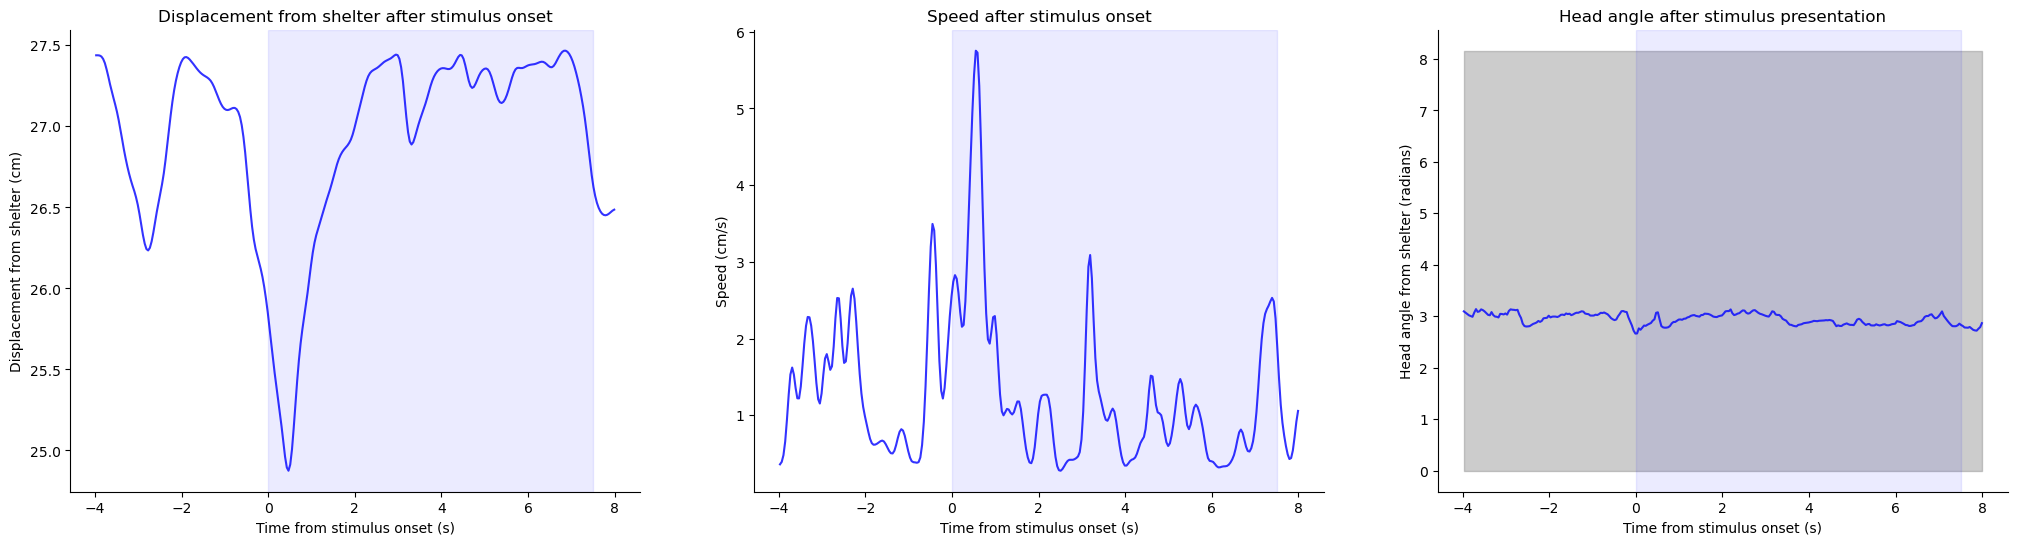

In [22]:
#change this for all of the code
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 6))

displacement_figure(ax1, -4, 8, coord_scaled, True, False, False, sigma)
speed_figure(ax2, -4, 8, coord_scaled, True, False, False, sigma)
head_angle_figure(ax3, -4, 8, coord_scaled, False, False,False, sigma)

<module 'matplotlib.pyplot' from 'C:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

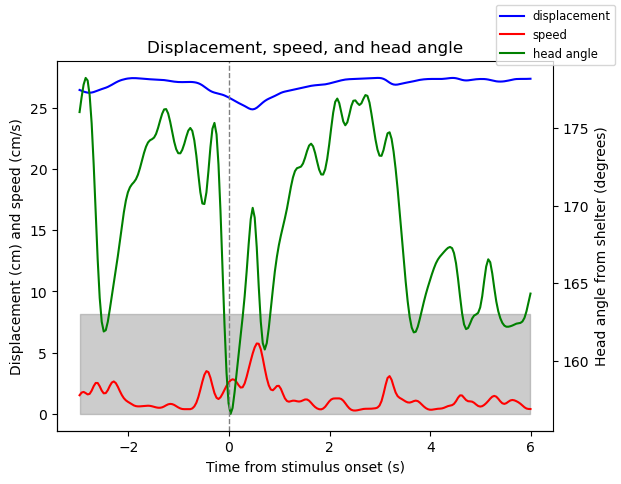

In [23]:
#overlay of displacement, speed, head angle
#parameters: start time, stop time, dataframe
combined_graphs(-3, 6, coord_scaled_smooth)

In [24]:
#likelihood_data, likelihood_minus_nose, likelihood_center = likelihood_check(0, 8, .9, coords)

In [25]:
"""
#new dataframe (rotate) with rotated coordinates and shelter at 0, 25

#parameters: converted shelter x, converted shelter y, start time, stop time, dataframe
#if moves away from shelter or freezes use escape estimate or you get an empty df 

rotate, shelter_rotate_x, shelter_rotate_y = align_shelter(shelter_x, shelter_y, 0, escape_done, coord_scaled)
"""

'\n#new dataframe (rotate) with rotated coordinates and shelter at 0, 25\n\n#parameters: converted shelter x, converted shelter y, start time, stop time, dataframe\n#if moves away from shelter or freezes use escape estimate or you get an empty df \n\nrotate, shelter_rotate_x, shelter_rotate_y = align_shelter(shelter_x, shelter_y, 0, escape_done, coord_scaled)\n'

In [26]:
"""
#visualize rotation above 
fig = plt.figure()  #create figure to fill in
ax = plt.axes()
    
    #make x and y scales equal - present as a circle


    #plot the center x and y coordinates
x = rotate['rotated_x']
y = rotate['rotated_y']

ax.text(shelter_rotate_x,shelter_rotate_y, 'S', color = 'black', size = 10)
shelter = patches.Rectangle(((shelter_rotate_x - 5.25), (shelter_rotate_y-6.25)), 10.5,12.5,  linewidth = .8, edgecolor = 'none', facecolor = 'blue', alpha = .1)
ax.add_patch(shelter)

ax.set_aspect('equal')
ax.plot(x,y, color = 'blue', linewidth = 1)
"""

"\n#visualize rotation above \nfig = plt.figure()  #create figure to fill in\nax = plt.axes()\n    \n    #make x and y scales equal - present as a circle\n\n\n    #plot the center x and y coordinates\nx = rotate['rotated_x']\ny = rotate['rotated_y']\n\nax.text(shelter_rotate_x,shelter_rotate_y, 'S', color = 'black', size = 10)\nshelter = patches.Rectangle(((shelter_rotate_x - 5.25), (shelter_rotate_y-6.25)), 10.5,12.5,  linewidth = .8, edgecolor = 'none', facecolor = 'blue', alpha = .1)\nax.add_patch(shelter)\n\nax.set_aspect('equal')\nax.plot(x,y, color = 'blue', linewidth = 1)\n"

In [27]:
#try plotting all of P1s trajectory 